# TP 7 : la méthode du gradient proximal pour le lasso

## Génération des données du problème

In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import time

n = 200              # number of examples (you can try with n = 1000 and n = 5000 (it may take some time...))
p = 2*n              # dimensionality of the problem

k = 5                # number of active variables
# creating features and normalizing them (normalization is not necessary)
np.random.seed(0)
X = np.random.randn(n,p)
X = (X - np.mean(X,axis = 0))/np.std(X,axis = 0)

t = np.arange(0,p)/(p-1);   # bulding the variance matrix !
S = np.zeros((p,p))
nn = 0.00001
for i in range(p):
    S[i,:] = np.exp(-(t-t[i])**2/nn);

X = X@(S**.5)
#X = X/np.std(X,axis = 0)
X = X/np.linalg.norm(X,axis=0)
X = np.array(X, order='F')


# generating optimal weights
ind = np.random.choice(p, k, replace=False)
weights = np.random.randn(k)
weights += 0.1+np.sign(weights)  # to get large enough weight

wopt = np.zeros(p)
wopt[ind] = weights

(CVXPY) Dec 29 08:50:02 AM: Encountered unexpected exception importing solver OSQP:
ImportError("dlopen(/Users/stephane/anaconda3/lib/python3.11/site-packages/osqp/_osqp.cpython-311-darwin.so, 0x0002): symbol not found in flat namespace '_csc_matrix'")


In [2]:
# generating output by X@w + noise
rsnr = 2
z = X[:,ind]@weights
stdnoise = np.std(z)/rsnr
y = z + stdnoise*np.random.randn(n)

In [3]:
def lasso_cost(X,y,b,lamb):
    return (.5*np.sum((X@b-y)**2) + lamb*np.sum(np.abs(b)))

## Solution de référence avec CVX

In [4]:
import cvxpy as cvx

lambd = 0.001*n;
w = cvx.Variable(p)
objective = cvx.Minimize(0.5*cvx.sum_squares(X@w - y) + lambd*cvx.norm(w,1))
tic = time.time()
pr = cvx.Problem(objective)
result = pr.solve()
toc = time.time() - tic
wcvx = w.value
#print(wcvx)

/Users/stephane/anaconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/Users/stephane/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Execution time for the CVX Lasso regression: 0.2113
Test error for the CVX Lasso regression: 0.3323
2.7087914756528857


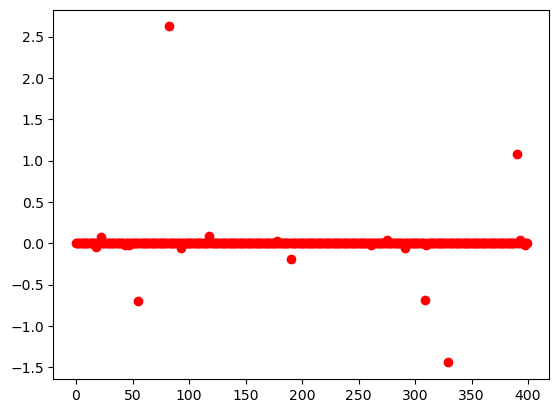

In [5]:
print("Execution time for the CVX Lasso regression: {:0.4f}".format(toc))
e_prox = np.sum((X@wcvx-z)**2)
print("Test error for the CVX Lasso regression: {:0.4f}".format(e_prox))

print(lasso_cost(X,y,wcvx,lambd))

plt.plot(wcvx,'or')
plt.show()

## Codage du proxL1

$v = argmin_u \quad \lambda||u||_1 + \frac{1}{2} ||u-w||^2$

$prox_{l1}(w) = sign(w) max(|w| - \lambda, 0)$

In [6]:
def proxl1(w,lam):
    v = np.sign(w)*np.maximum((np.abs(w)-lam),0)
    return(v)

In [7]:
a = np.array([1.5, -2, 1, -1., 2., -3.])
print(proxl1(a,1.5))

[ 0.  -0.5  0.  -0.   0.5 -1.5]


In [8]:
def prox_grad(X,y,w, lambd=1, prox=proxl1,nb_itermax=100000):
    """Computes the Lasso regression coefficients using the proximal gradient algorithm.

      Args:
    X: A numpy array of shape (n_samples, n_features) representing the design matrix.
    y: A numpy array of shape (n_samples,) representing the target vector.
    w: A numpy array of shape (n_features) representing the inital vaue of the Lasso regression coefficients
    lambd: The regularization parameter.

      Returns:
    w A numpy array of shape (n_features,) representing the Lasso regression coefficients.
    """

    stepsize = 1/np.linalg.norm(X.T@X)
    for i in range(nb_itermax):
        grad = -X.T@(y-X@w)
        w = w - stepsize*grad
        w = prox(w,stepsize*lambd)
        
        if prox == proxl1: 
            exactOnzeros, exactOnNonZeros = test_opt_l1(X,y,w,lambd)
            if exactOnzeros < 0 and exactOnNonZeros < 1e-6:
                break
    
    return w

def test_opt_l1(X,y, w, lambd):

    epsi = 1e-3
    indzero = np.where(np.abs(w)<epsi)
    indnonzero = np.where(np.abs(w)>epsi)
    grad =  -X.T@(y - X@w)
    exactOnzeros = -1
    exactOnNonZeros = 0
    if indzero[0].shape[0]> 0:
        exactOnzeros = np.max(np.abs(grad[indzero]) - lambd)
    if indnonzero[0].shape[0] > 0:
        exactOnNonZeros = np.max(np.abs(grad[indnonzero] + lambd*np.sign(w[indnonzero])))
    return exactOnzeros, exactOnNonZeros


In [9]:
w = np.zeros(p)
lambd = 0.001*n;

tic = time.time()
w_prox = prox_grad(X,y,w.copy(),lambd = lambd,prox = proxl1, nb_itermax=5000)
toc = time.time() - tic


Execution time for the prox Lasso regression: 0.9337
Test error for the prox Lasso regression: 0.3323
2.708791482144564


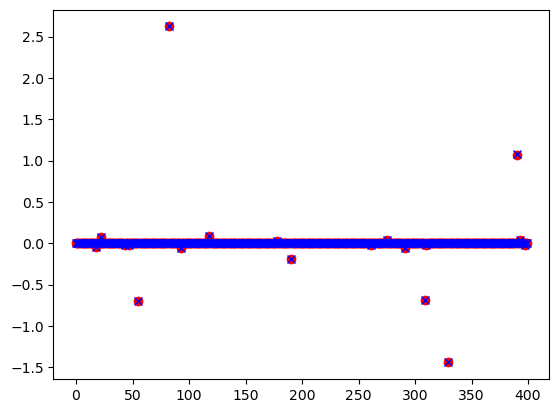

In [10]:
print("Execution time for the prox Lasso regression: {:0.4f}".format(toc))
e_prox = np.sum((X@w_prox-z)**2)
print("Test error for the prox Lasso regression: {:0.4f}".format(e_prox))

print(lasso_cost(X,y,w_prox,lambd))

plt.plot(w_prox,'or')
plt.plot(wcvx,'xb')

plt.show()

## Copilot solution 

With the prompt "Can you give me a python function computing the lasso regression coeficiant of a disign matrix X with a target vector y and a regularisation parameter l, without using sklearn and using the proximal gradient algorithm?"

I've got the following piece of code


In [11]:
import numpy as np

def lasso_regression(X, y, l, alpha, max_iter):
    n, p = X.shape
    beta = np.zeros(p)
    X_centered = X - np.mean(X, axis=0)
    y_centered = y - np.mean(y)
    for i in range(max_iter):
        beta_old = beta.copy()
        gradient = X_centered.T @ (X_centered @ beta - y_centered)
        beta = soft_threshold(beta - alpha * gradient, l * alpha)
        if np.linalg.norm(beta - beta_old) < 1e-4:
            break
    return beta

def soft_threshold(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

In [12]:
l = 0.001*n;
stepsize = 1/np.linalg.norm(X.T@X)

tic = time.time()
w_prox_gpt = lasso_regression(X,y,l, alpha=stepsize , max_iter=3000)
toc = time.time() - tic

Execution time for the prox Lasso regression: 0.1373
Test error for the prox Lasso regression: 0.3344
2.708885677081417


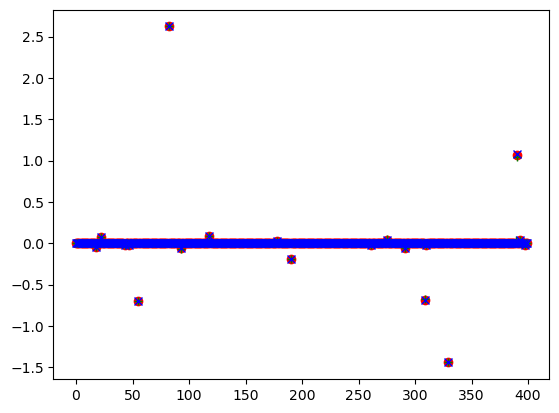

In [13]:
print("Execution time for the prox Lasso regression: {:0.4f}".format(toc))
e_prox_gpt = np.sum((X@w_prox_gpt-z)**2)
print("Test error for the prox Lasso regression: {:0.4f}".format(e_prox_gpt))

print(lasso_cost(X,y,w_prox_gpt,lambd))

plt.plot(w_prox,'or')
plt.plot(w_prox_gpt,'+g')
plt.plot(wcvx,'xb')

plt.show()